In [ ]:
import os
import random

from collections import Counter, defaultdict
from itertools import combinations

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

import numpy as np
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from word2number import w2n

--------------------
Dataset Overview:
Total entries (images): 44521
Unique image files: 44521
--------------------
Split distribution:
split
train    35614
test      4454
val       4453
Name: count, dtype: int64
--------------------
Missing images: 0
--------------------
Caption Length (in tokens):
Min: 4
Max: 50
Mean: 11.10
--------------------
Caption Length (in characters):
Min: 20
Max: 268
Mean: 61.74
--------------------
Vocabulary Size: 4118
--------------------
Top 20 Most Frequent Words:
the: 205462
a: 117735
are: 110696
and: 100620
is: 77969
there: 73835
of: 69650
some: 62069
many: 61772
green: 61299
on: 55440
in: 54666
trees: 51464
buildings: 47143
with: 42958
to: 26743
next: 24639
area: 24355
by: 21303
two: 18839


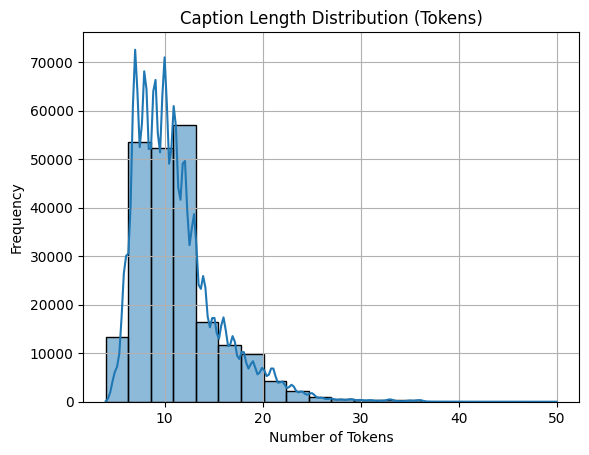

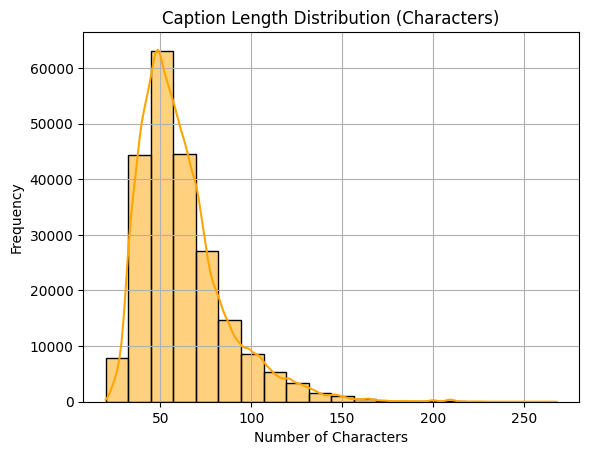

In [ ]:
# ----- DATASET OVERVIEW -----

csv_path = 'RISCM/captions.csv'
df = pd.read_csv(csv_path)
print("--------------------")
print("Dataset Overview:")
print(f"Total entries (images): {len(df)}")
print(f"Unique image files: {df['image'].nunique()}")
print("--------------------")
print("Split distribution:")
print(df['split'].value_counts())
print("--------------------")

# Verify that all images exist
image_folder = 'RISCM/resized'
missing_images = [img for img in df['image'] if not os.path.exists(os.path.join(image_folder, img))]
print(f"Missing images: {len(missing_images)}")

# ----- CAPTION STATISTICS -----
all_captions = df[[f'caption_{i}' for i in range(1, 6)]].values.flatten()

def preprocess_caption(caption):
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(caption)

tokenized_captions = [preprocess_caption(cap) for cap in all_captions if isinstance(cap, str)]
caption_lengths = [len(tokens) for tokens in tokenized_captions]
char_lengths = [len(cap) for cap in all_captions if isinstance(cap, str)]

print("--------------------")
print("Caption Length (in tokens):")
print(f"Min: {min(caption_lengths)}")
print(f"Max: {max(caption_lengths)}")
print(f"Mean: {sum(caption_lengths)/len(caption_lengths):.2f}")
print("--------------------")
print("Caption Length (in characters):")
print(f"Min: {min(char_lengths)}")
print(f"Max: {max(char_lengths)}")
print(f"Mean: {sum(char_lengths)/len(char_lengths):.2f}")
print("--------------------")
flat_tokens = [token for sublist in tokenized_captions for token in sublist]
vocab = set(flat_tokens)
print(f"Vocabulary Size: {len(vocab)}")
print("--------------------")
counter = Counter(flat_tokens)
print("Top 20 Most Frequent Words:")
for word, freq in counter.most_common(20):
    print(f"{word}: {freq}")

# ----- VISUALIZATIONS -----
sns.histplot(caption_lengths, bins=20, kde=True)
plt.title("Caption Length Distribution (Tokens)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

sns.histplot(char_lengths, bins=20, kde=True, color='orange')
plt.title("Caption Length Distribution (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Total number of duplicate captions in the dataset: 14632


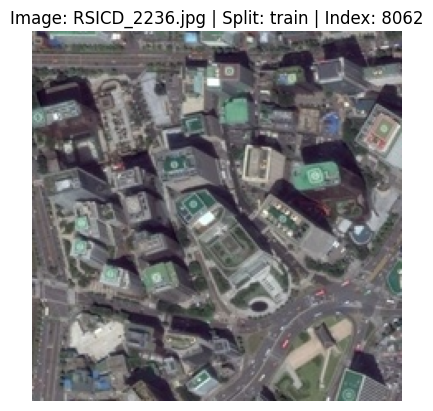


Captions of the image:
1. many buildings and green trees are in a commercial area .
2. many buildings and green trees are in a commercial area .
3. many buildings and green trees are in a commercial area .
4. many buildings and green trees are in a commercial area .
5. many buildings and green trees are in a commercial area .


In [ ]:
# ----- CHECK FOR DUPLICATE CAPTIONS -----

def count_duplicates(df):
    total_duplicates = 0
    
    for idx, row in df.iterrows():
        captions = [row[f'caption_{i}'] for i in range(1, 6)]
        caption_counts = Counter(captions)
        
        total_duplicates += sum(count > 1 for count in caption_counts.values())
    
    return total_duplicates

# ----- DISPLAY EXAMPLE DUPLICATE -----

def display_random(df, image_folder='RISCM/resized'):
    images_with_duplicates = []
    for idx, row in df.iterrows():
        captions = [row[f'caption_{i}'] for i in range(1, 6)]
        caption_counts = Counter(captions)
        
        if any(count > 1 for count in caption_counts.values()):
            images_with_duplicates.append((idx, row))
    
    if not images_with_duplicates:
        print("No images with duplicate captions found.")
        return
    
    random_image = random.choice(images_with_duplicates)
    idx, row = random_image
    image_id = row['image']
    split = row['split']
    image_path = os.path.join(image_folder, image_id)
    
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {image_id} | Split: {split} | Index: {idx}")
    plt.show()

    print(f"\nCaptions of the image:")
    for i in range(1, 6):
        caption = row[f'caption_{i}']
        print(f"{i}. {caption}")
        
num_duplicates = count_duplicates(df)
print(f"Total number of duplicate captions in the dataset: {num_duplicates}")

display_random(df)


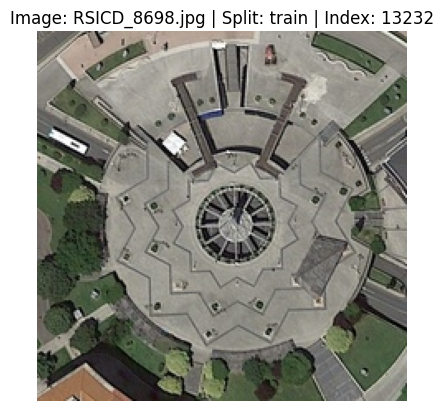


Caption Frequency Summary:
Caption: 'some green trees are in a circle square .' | Occurrences: 5
This image has 4 duplicate captions.


In [ ]:
# ----- DUPLICATE INSPECTION -----

def inspect(df, index, image_folder='RISCM/resized'):
    if index < 0 or index >= len(df):
        print(f"Index {index} is out of bounds. Valid range: 0 to {len(df) - 1}")
        return

    row = df.iloc[index]
    image_id = row['image']
    split = row['split']
    image_path = os.path.join(image_folder, image_id)

    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {image_id} | Split: {split} | Index: {index}")
    plt.show()

    captions = [row[f'caption_{i}'] for i in range(1, 6)]
    caption_counts = Counter(captions)

    print("\nCaption Frequency Summary:")
    for caption, count in caption_counts.items():
        print(f"Caption: '{caption}' | Occurrences: {count}")

    unique_captions = len(caption_counts)
    
    if unique_captions < 5:
        print(f"This image has {5 - unique_captions} duplicate captions.")
    else:
        print("All captions for this image are unique.")

inspect(df, 13232)


In [ ]:
# ----- PRINT ALL DUPLICATES -----

def all_duplicates(df):
    image_duplicates = []
    caption_duplicates_per_image = {}
    
    for idx, row in df.iterrows():
        image_id = row['image']
        captions = [row[f'caption_{i}'] for i in range(1, 6)]
        
        if image_id in caption_duplicates_per_image:
            image_duplicates.append((image_id, idx, captions))
        else:
            caption_duplicates_per_image[image_id] = []
        
        caption_counts = Counter(captions)
        for caption, count in caption_counts.items():
            if count > 1:
                caption_duplicates_per_image[image_id].append((caption, count))
    
    return caption_duplicates_per_image

caption_duplicates_per_image = all_duplicates(df)

for image_id, caption_counts in caption_duplicates_per_image.items():
    if len(caption_counts) > 1:
        print(f"\nImage ID: {image_id} - Redundant Captions:")
        for caption, count in caption_counts:
            if count > 1:
                print(f"Caption: '{caption}' appears {count} times")



Image ID: RSICD_1.jpg - Redundant Captions:
Caption: 'some planes are parked in an airport .' appears 3 times
Caption: 'the airport here is full of airplanes and containers .' appears 2 times

Image ID: RSICD_2.jpg - Redundant Captions:
Caption: 'many planes are parked in an airport near many runways .' appears 3 times
Caption: 'there are many planes with same size in the airport .' appears 2 times

Image ID: RSICD_4.jpg - Redundant Captions:
Caption: 'several buildings and green trees are around a piece of bare land.' appears 3 times
Caption: 'some planes are parked near an airport with parking lot .' appears 2 times

Image ID: RSICD_5.jpg - Redundant Captions:
Caption: 'some green trees are near a large piece of bare land.' appears 3 times
Caption: 'some planes are parked near an airport with parking lot .' appears 2 times

Image ID: RSICD_6.jpg - Redundant Captions:
Caption: 'many planes are parked between several buildings and many runways .' appears 3 times
Caption: 'several runw

Computing Similarity: 100%|██████████| 44521/44521 [04:59<00:00, 148.87it/s]



Dataset-level BLEU-4 Intra-Caption Similarity:
Mean: 0.2142
Std: 0.2968
Min: 0.0138
Max: 1.0000

Dataset-level METEOR Intra-Caption Similarity:
Mean: 0.4042
Std: 0.2401
Min: 0.0951
Max: 1.0000

Dataset-level Cosine Similarity:
Mean: 0.3349
Std: 0.2668
Min: 0.0246
Max: 1.0000


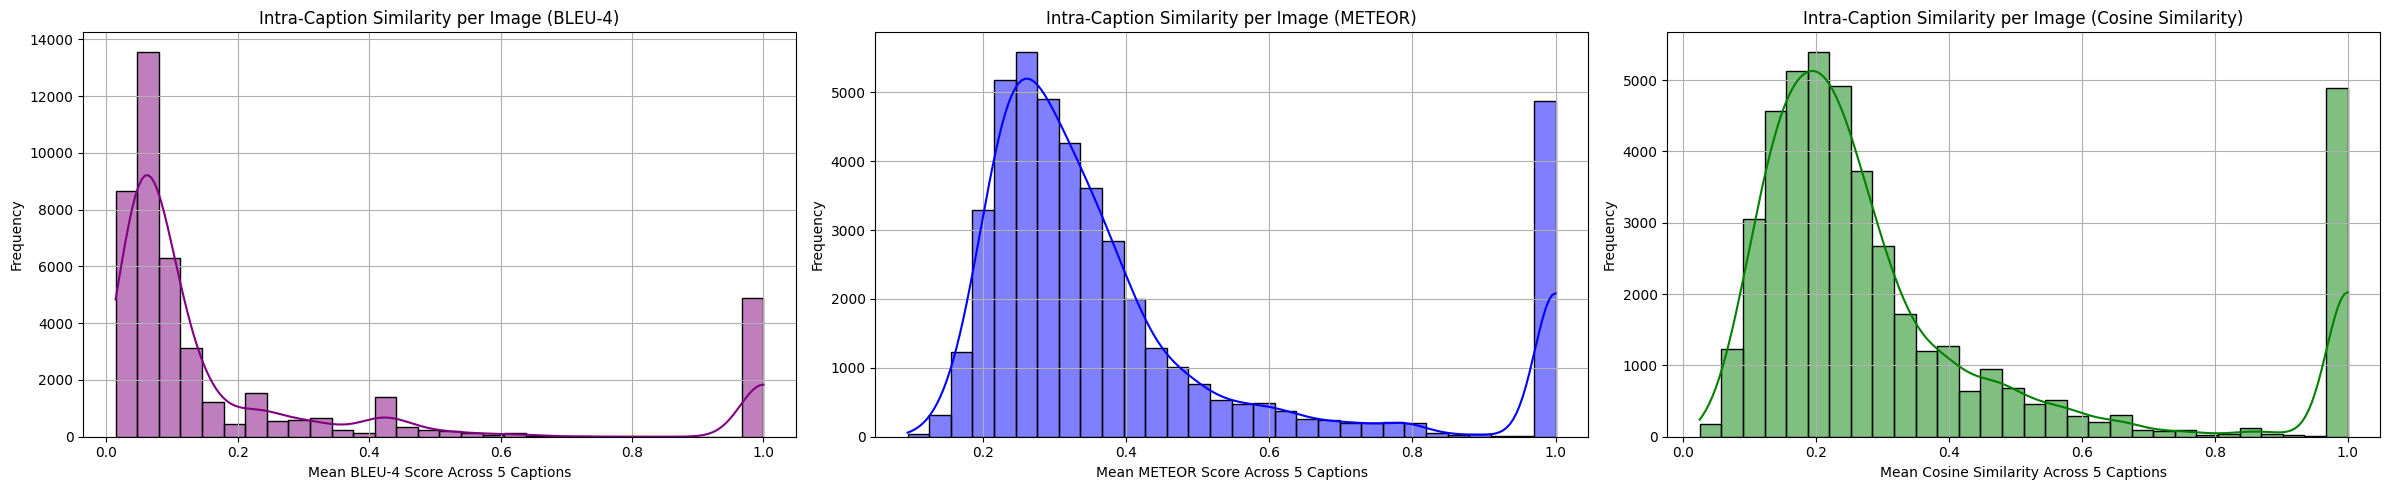

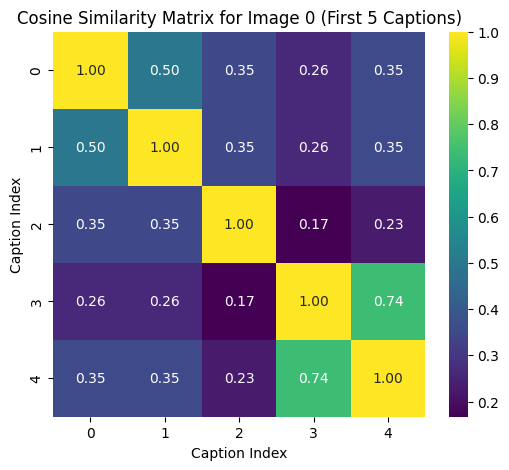

In [ ]:
# ----- SIMILARITY METRICS -----

def compute_pairwise_bleu(captions):
    scores = []
    for i, j in combinations(range(5), 2):
        ref = [captions[i]]
        hyp = captions[j]
        score = sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method4)
        scores.append(score)
    return np.mean(scores)

def compute_pairwise_meteor(captions):
    scores = []
    for i, j in combinations(range(5), 2):
        ref = captions[i]
        hyp = captions[j]
        score = min(1.0, meteor_score([ref], hyp))
        scores.append(score)
    return np.mean(scores)

def compute_cosine_similarity(captions):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(captions)
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    indices = np.triu_indices(5, 1)
    return np.mean(cosine_sim_matrix[indices]), cosine_sim_matrix

bleu_scores = []
meteor_scores = []
cosine_scores = []
cosine_matrices = []

for idx, row in tqdm.tqdm(df.iterrows(), total=len(df), desc="Computing Similarity"):
    captions_raw = [str(row[f'caption_{i}']).lower() for i in range(1, 6)]
    captions_tok = [cap.split() for cap in captions_raw]

    bleu_scores.append(compute_pairwise_bleu(captions_tok))
    meteor_scores.append(compute_pairwise_meteor(captions_tok))
    
    mean_cosine, cosine_matrix = compute_cosine_similarity(captions_raw)
    cosine_scores.append(mean_cosine)
    cosine_matrices.append(cosine_matrix)

df['mean_bleu'] = bleu_scores
df['mean_meteor'] = meteor_scores
df['mean_cosine'] = cosine_scores

# Summary stats
print(f"\nDataset-level BLEU-4 Intra-Caption Similarity:")
print(f"Mean: {np.mean(bleu_scores):.4f}")
print(f"Std: {np.std(bleu_scores):.4f}")
print(f"Min: {np.min(bleu_scores):.4f}")
print(f"Max: {np.max(bleu_scores):.4f}")

print(f"\nDataset-level METEOR Intra-Caption Similarity:")
print(f"Mean: {np.mean(meteor_scores):.4f}")
print(f"Std: {np.std(meteor_scores):.4f}")
print(f"Min: {np.min(meteor_scores):.4f}")
print(f"Max: {np.max(meteor_scores):.4f}")

print(f"\nDataset-level Cosine Similarity:")
print(f"Mean: {np.mean(cosine_scores):.4f}")
print(f"Std: {np.std(cosine_scores):.4f}")
print(f"Min: {np.min(cosine_scores):.4f}")
print(f"Max: {np.max(cosine_scores):.4f}")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

sns.histplot(bleu_scores, bins=30, kde=True, color='purple', ax=axes[0])
axes[0].set_title("Intra-Caption Similarity per Image (BLEU-4)")
axes[0].set_xlabel("Mean BLEU-4 Score Across 5 Captions")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

sns.histplot(meteor_scores, bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Intra-Caption Similarity per Image (METEOR)")
axes[1].set_xlabel("Mean METEOR Score Across 5 Captions")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

sns.histplot(cosine_scores, bins=30, kde=True, color='green', ax=axes[2])
axes[2].set_title("Intra-Caption Similarity per Image (Cosine Similarity)")
axes[2].set_xlabel("Mean Cosine Similarity Across 5 Captions")
axes[2].set_ylabel("Frequency")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Cosine similarity heatmap for the first image
plt.figure(figsize=(6, 5))
sns.heatmap(cosine_matrices[0], annot=True, cmap='viridis', fmt=".2f")
plt.title("Cosine Similarity Matrix for Image 0 (First 5 Captions)")
plt.xlabel("Caption Index")
plt.ylabel("Caption Index")
plt.show()


In [ ]:
# ----- CONTRADICTORY OBJECT NUMBER DETECTION -----

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Convert word numbers to digits
def normalize_number(text):
    try:
        return w2n.word_to_num(text.lower())
    except:
        if re.fullmatch(r'\d+', text):
            return int(text)
        return None

def object_count(caption):
    doc = nlp(caption)
    object_counts = defaultdict(int)

    # Step 1: Handle explicit numerals and count objects
    for token in doc:
        if token.pos_ == 'NUM':
            number = normalize_number(token.text)
            if number is not None:
                head = token.head
                if head.pos_ == 'NOUN':
                    noun = head.lemma_.lower()
                    object_counts[noun] += number
                else:
                    for right in token.rights:
                        if right.pos_ == 'NOUN':
                            noun = right.lemma_.lower()
                            object_counts[noun] += number
                            break

    # Step 2: Handle implicit singular determiners (like "a", "an", "one")
    singular_dets = {"a", "an", "one", "single"}
    for token in doc:
        if token.pos_ == 'DET' and token.text.lower() in singular_dets:
            head = token.head
            if head.pos_ == 'NOUN':
                noun = head.lemma_.lower()
                object_counts[noun] += 1

    # Return quantified objects as a list of tuples
    quantified = [(count, obj) for obj, count in object_counts.items()]
    return quantified

example = "A small plane and two big planes with a car parked next to boarding bridges while some white facilities and a tower around them ."
quantified = object_count(example)
print("Quantified:", quantified)

C:\Users\iedev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Quantified: [(3, 'plane'), (1, 'car'), (1, 'tower')]


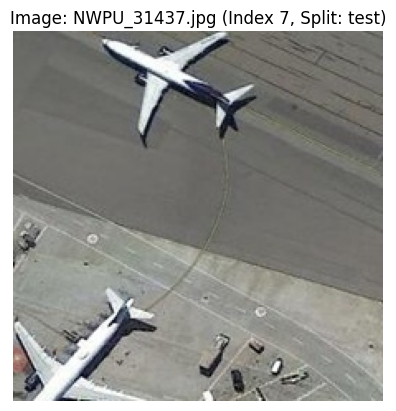

Captions for image: NWPU_31437.jpg
1. A plane parked on the open area and the passing plane behind it .
2. Here are two white planes, One of which has a dark blue tail .
3. There are two planes of different sizes on a clearing .
4. Two planes are parked on the runway .
5. Two planes are on the marked ground .

Count disagreement for 'plane': counts mentioned = [1, 2, 2, 2, 2]
--------------------------------------------------------------------------------


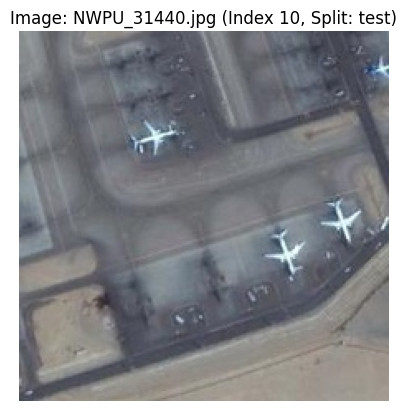

Captions for image: NWPU_31440.jpg
1. Four planes parked at three airports .
2. Three planes parked on white open space .
3. Several planes of the same size parked neatly next to the buildings inside the airport .
4. Three planes are parked on the open space next to the bare land .
5. Three planes are on the marked ground .

Count disagreement for 'plane': counts mentioned = [4, 3, 3, 3]
--------------------------------------------------------------------------------


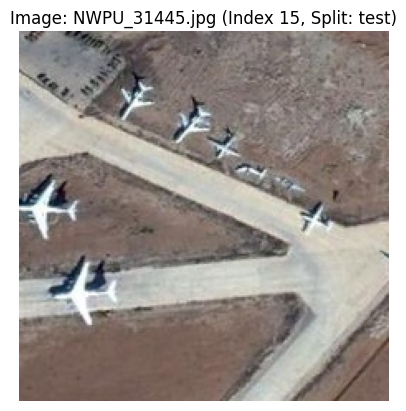

Captions for image: NWPU_31445.jpg
1. Some planes of different sizes parked on the open area and another one on the runway .
2. Two planes are on the runway and four are parked on the ground .
3. There is a plane on the runway and three planes in the open space next to the runway .
4. Many gray planes are parked on the bare ground and on the runway .
5. There are six planes on the ground .

Count disagreement for 'plane': counts mentioned = [2, 4, 6]
--------------------------------------------------------------------------------


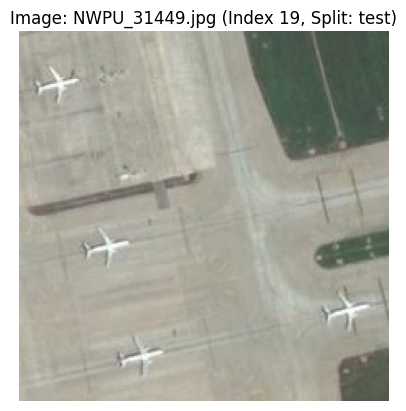

Captions for image: NWPU_31449.jpg
1. Three planes parked in a line on the airport and the passing plane in front of them .
2. There were four white aircraft on the ground, One of which was not on the same line as the other three .
3. There are many planes of the same size in a clearing, With large lawns beside the clearing .
4. Four planes are parked on the runway next to the grass .
5. Four planes are in the clearing next to the grass .

Count disagreement for 'plane': counts mentioned = [3, 4, 4]
--------------------------------------------------------------------------------


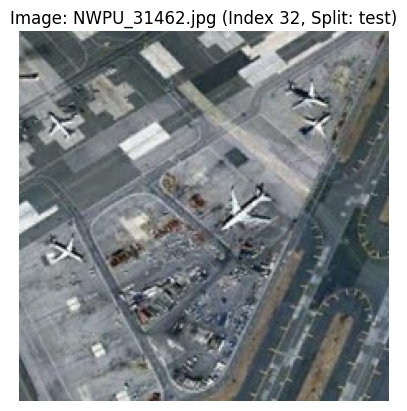

Captions for image: NWPU_31462.jpg
1. Some planes parked in different directions on the open area with some marks .
2. There are five aircraft on the open ground, The largest of which is three times as large as the smallest one .
3. There is an airplane on the runway, Four airplanes in the open space next to the runway, And many cars parked in the open space next to the airplane .
4. Four planes are parked on the open space next to the runway .
5. Five planes are on the marked ground .

Count disagreement for 'plane': counts mentioned = [4, 5]
--------------------------------------------------------------------------------


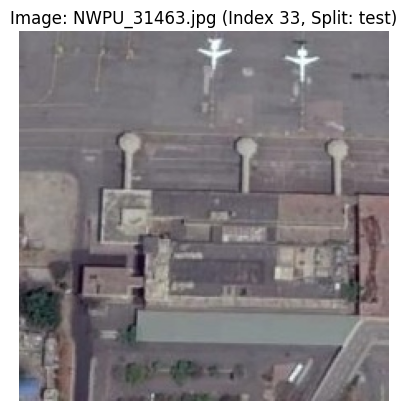

Captions for image: NWPU_31463.jpg
1. Two adjacent planes parked next to boarding bridges of the terminal .
2. There are three aircraft on the open ground .
3. Two planes parked in a clearing, With many buildings next to the plane .
4. Two planes are parked on the open space next to the terminal .
5. Three planes were in the clearing next to the buildings .

Count disagreement for 'plane': counts mentioned = [2, 2, 2, 3]
--------------------------------------------------------------------------------


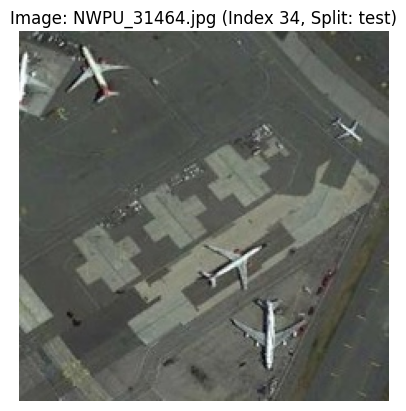

Captions for image: NWPU_31464.jpg
1. Three planes parked in different directions on the open area with some marks .
2. There are four aircraft on the open ground, The largest of which is five times as large as the smallest one .
3. There are many planes of different sizes in a clearing .
4. Three big planes and a small plane are parked on the runway .
5. Four planes of different sizes were on the ground .

Count disagreement for 'plane': counts mentioned = [3, 4, 4]
--------------------------------------------------------------------------------


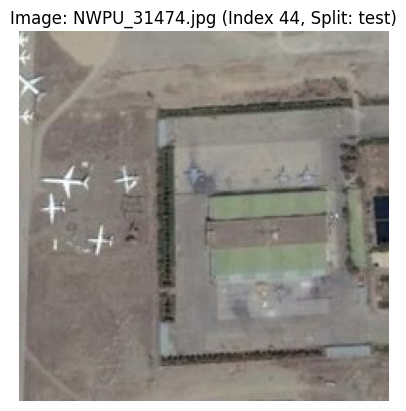

Captions for image: NWPU_31474.jpg
1. Some white planes of different sizes parked in different directions on the open area and some gray planes of different sizes parked in a yard with the green building .
2. There are about ten white and three gray planes here .
3. Several planes of different sizes are parked in a clearing, With many buildings next to the plane .
4. Many planes are parked on the open space next to the buildings .
5. There are eight planes on the ground .

Count disagreement for 'plane': counts mentioned = [10, 8]
--------------------------------------------------------------------------------


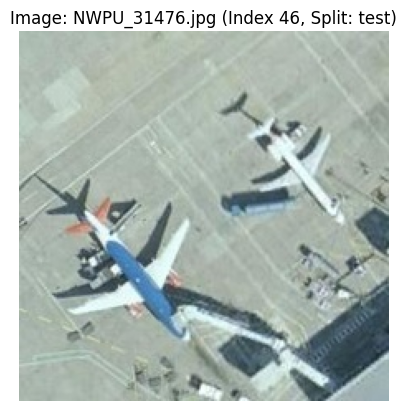

Captions for image: NWPU_31476.jpg
1. A blue plane and a white plane parked next to boarding bridges .
2. Here are two planes and a blue truck .
3. A white plane and a blue fuselage parked neatly next to the buildings inside the airport .
4. A blue plane and a white plane are parked on the open space beside the terminal .
5. Two planes are on the marked ground .

Count disagreement for 'plane': counts mentioned = [2, 2, 1, 2, 2]
--------------------------------------------------------------------------------

Objects with count contradictions across the subset:
['plane']


In [ ]:
def analyze_captions(row, image_idx, image_folder='RISCM/resized'):
    object_counts = defaultdict(list)
    caption_texts = []
    
    for i in range(1, 6):
        caption = str(row[f'caption_{i}'])
        caption_texts.append(caption)
        quantified = object_count(caption)
        for count, obj in quantified:
            object_counts[obj].append(count)

    count_disagreements = {obj: counts for obj, counts in object_counts.items() if len(set(counts)) > 1}
    
    if not count_disagreements:
        return []

    contradictory_objects = list(count_disagreements.keys())

    image_path = os.path.join(image_folder, row['image'])
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {row['image']} (Index {image_idx}, Split: {row['split']})")
        plt.show()
    else:
        print(f"[!] Image file not found: {image_path}")

    print(f"Captions for image: {row['image']}")
    for i, cap in enumerate(caption_texts, 1):
        print(f"{i}. {cap}")

    for obj, counts in count_disagreements.items():
        print(f"\nCount disagreement for '{obj}': counts mentioned = {counts}")

    print("-" * 80)
    
    return contradictory_objects

all_contradictory_objects = set()
subset = df.head(50)
for idx, row in subset.iterrows():
    contradictory_objects = analyze_captions(row, idx)
    all_contradictory_objects.update(contradictory_objects)

print("\nObjects with count contradictions across the subset:")
print(list(all_contradictory_objects))